# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
%load_ext autoreload
%autoreload 2


import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier




## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Mon Feb 26 17:05:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P4             588W /  55W |     12MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "local-bert"

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [5]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Plotting Word Cloud 

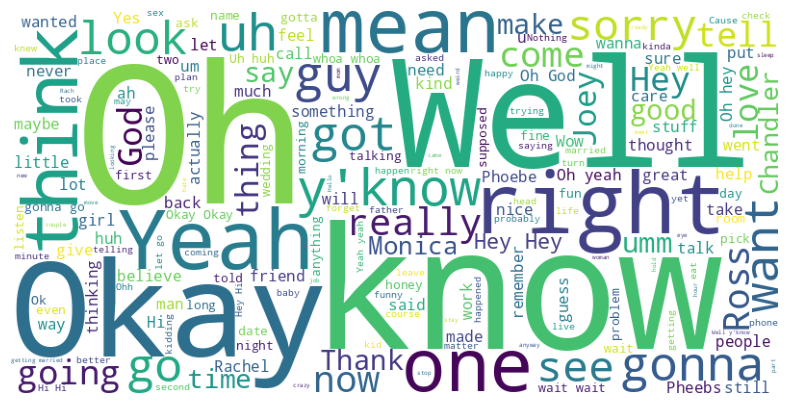

In [6]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [7]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}


### Taking a look to same utterance example

In [8]:
display_dialogue(dataframe=df, utterance_id='utterance_6')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')


Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Removing NaN Values

In [9]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Analyzing the dataset

In [10]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in an utterance: {speakers['min_speakers']}")
print(f"Maximum number of speakers in an utterance: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in an utterance: {utterances['length_min']}")
print(f"Maximum number of sentences in an utterance: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in an utterance: 1
Maximum number of speakers in an utterance: 8

Minimum number of sentences in an utterance: 2
Maximum number of sentences in an utterance: 24


In [11]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Appling some preprocessing operations 

In the following cell, individual utterances constituting a dialogue are concatenated to form a single string while preserving separation through the addition of the token '[SEP]'.

In [12]:
df['processed_utterances'] = df['utterances'].apply(concat_with_sep)
df['processed_utterances']


episode
utterance_0       also I was the point person on my company's tr...
utterance_1       also I was the point person on my company's tr...
utterance_2       also I was the point person on my company's tr...
utterance_3       also I was the point person on my company's tr...
utterance_4       But then who? The waitress I went out with las...
                                        ...                        
utterance_3995    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3996    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3997    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3998    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
utterance_3999    Hey. [SEP] Hey! [SEP] So how was Joan? [SEP] I...
Name: processed_utterances, Length: 4000, dtype: object

### Splitting the dataset 

In [13]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_1169,"[Ross, Rachel, Ross, Rachel, Ross, Rachel, Ross]","[neutral, anger, anger, neutral, sadness, sadn...","[You don't know?! Rach, you balded my girlfrie...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]","You don't know?! Rach, you balded my girlfrien..."
utterance_1311,"[Chandler, Monica, Chandler, Monica]","[joy, surprise, surprise, neutral]","[Oh come on guys, it's not like I moved to Eur...","[0.0, 0.0, 1.0, 0.0]","Oh come on guys, it's not like I moved to Euro..."
utterance_3245,"[Ross, Phoebe, Ross, Phoebe, Ross, Phoebe, Ros...","[neutral, anger, sadness, anger, sadness, joy,...","[By the way, the week before your wedding you ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]","By the way, the week before your wedding you m..."
utterance_1829,"[Rachel, Monica, Rachel, Monica, Rachel, Monic...","[sadness, surprise, neutral, neutral, neutral,...","[Oh my God! Oh my God!!, Still crying?, Like a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Oh my God! Oh my God!! [SEP] Still crying? [SE...
utterance_2632,"[Monica, Rachel, Monica, Rachel]","[neutral, neutral, neutral, anger]","[All right, I'm gonna go steam my wedding dres...","[0.0, 0.0, 1.0, 0.0]","All right, I'm gonna go steam my wedding dress..."


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_642,"[Joey, Ross, Ross, Joey]","[anger, neutral, neutral, surprise]","[Man, I'm starving! What the hell was I thinki...","[0.0, 0.0, 1.0, 1.0]","Man, I'm starving! What the hell was I thinkin..."
utterance_2048,"[Ross, Carol, Ross, Carol, Ross, Ross, Ross]","[joy, joy, neutral, surprise, sadness, joy, ne...","[So honey, this morning was fun, huh? Me hoppi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","So honey, this morning was fun, huh? Me hoppin..."
utterance_320,"[Rachel, Ross, Rachel, Ross, Phoebe, Monica, P...","[sadness, neutral, sadness, sadness, joy, neut...","[Oh, are you sure you're ok?, Yeah., Does it s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","Oh, are you sure you're ok? [SEP] Yeah. [SEP] ..."
utterance_1251,"[Ross, Joey, Joey, Joey, Ross, Mona, Joey, Mona]","[surprise, neutral, neutral, neutral, neutral,...","[I just didn't see the fast song coming., Shh....","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]",I just didn't see the fast song coming. [SEP] ...
utterance_2315,"[Kim, Nancy, Rachel, Kim, Rachel, Nancy, Kim, ...","[neutral, joy, joy, neutral, neutral, neutral,...","[So, we're decided, no on plaid, yes on pink?,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","So, we're decided, no on plaid, yes on pink? [..."


,speakers,emotions,utterances,triggers,processed_utterances
index,,,,,
utterance_3075,"[Chandler, Phoebe, Monica, Chandler, Monica, C...","[surprise, neutral, neutral, neutral, neutral,...","[No-no-no-no. Hey!, Anyway, I should go. Okay...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","No-no-no-no. Hey! [SEP] Anyway, I should go. ..."
utterance_1666,"[Mike, Chandler, Monica, Chandler, Monica, Mon...","[neutral, anger, joy, neutral, anger, neutral,...","[Ok, so it's a tie again, 41 to 41., Ok, look!...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","Ok, so it's a tie again, 41 to 41. [SEP] Ok, l..."
utterance_1380,"[Rachel, Ross, Ross, Rachel, Dr. Long, Rachel,...","[sadness, neutral, neutral, sadness, neutral, ...",[Oh that's five Ross. Five women have had five...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Oh that's five Ross. Five women have had five ...
utterance_1945,"[Rachel, Rachel]","[surprise, joy]","[I can't believe you don't want to know., I me...","[0.0, 0.0]",I can't believe you don't want to know. [SEP] ...
utterance_1140,"[Chandler, Issac, Chandler, Joey, Issac, Chand...","[joy, neutral, fear, neutral, neutral, joy]",[Come on Chloe! Finish up with your customer f...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Come on Chloe! Finish up with your customer fi...


### Visualizing the distribution of the emotions over the datasets

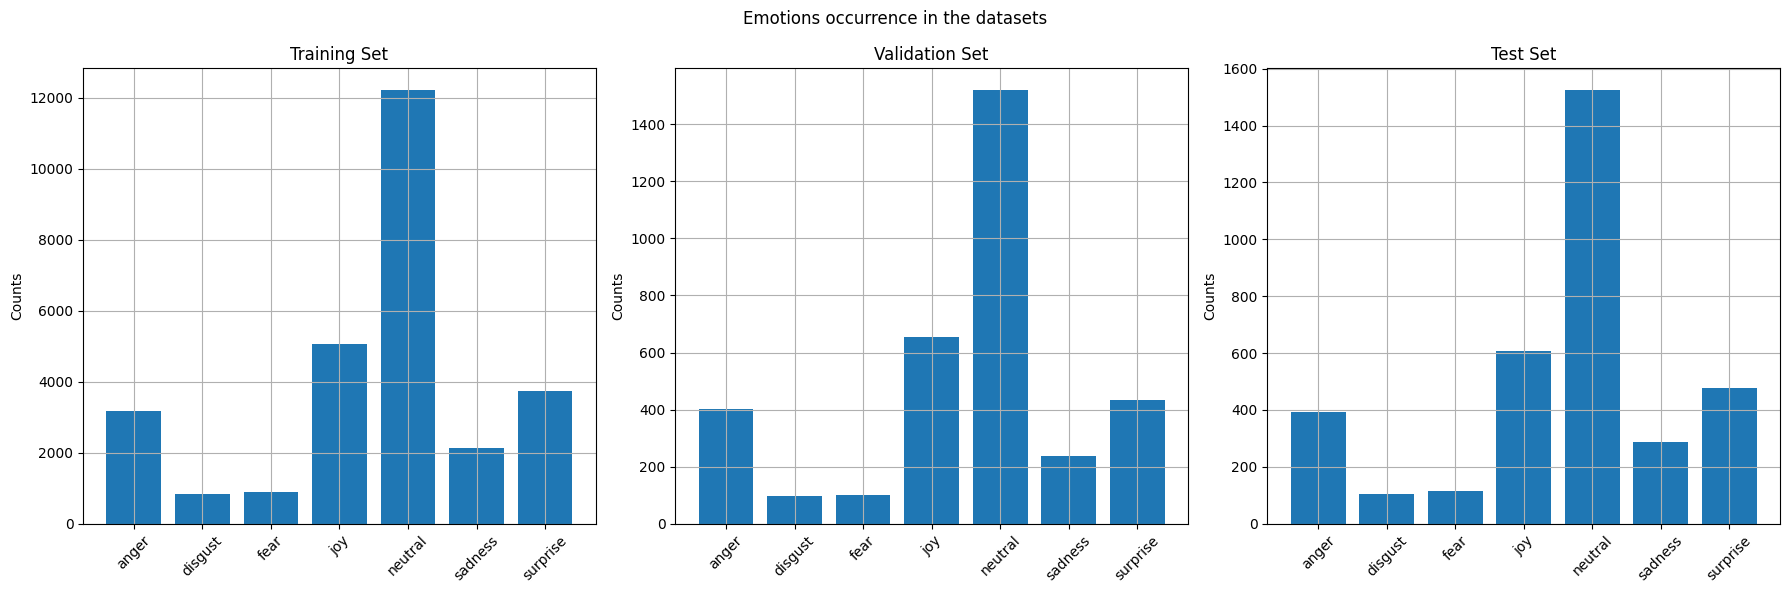

In [14]:
plot_emotion_distribution(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [15]:
from IPython.display import display
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
trigger_weights = create_classes_weights(df['triggers'].sum())

print('Emotion weights')
display(pd.DataFrame({'Emotion': EMOTIONS, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': [0, 1], 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426


Trigger weights


,Trigger,Weight
0,0,0.594761
1,1,3.138206


## Random Classifier

In [16]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.drop(columns='processed_utterances').copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_dialogue(dataframe=new_test_df, utterance_id=0)  


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Chandler,surprise,No-no-no-no. Hey!,0.0,anger,0
1,Phoebe,neutral,"Anyway, I should go. Okay, bye.",0.0,sadness,1
2,Monica,neutral,Hey sweetie.,0.0,anger,1
3,Chandler,neutral,"Hi sweetie. So, what was with all the whispering?",0.0,fear,1
4,Monica,neutral,I can't tell you. It's a secret.,0.0,sadness,1
5,Chandler,anger,Secret? Married people aren't supposed to have...,0.0,sadness,1
6,Monica,neutral,Awww. But still no.,0.0,fear,1
7,Chandler,neutral,"No I'm serious, we should tell each other",0.0,sadness,1
8,Monica,neutral,"Really? Okay, so why don't you tell me what ha...",0.0,fear,0
9,Chandler,fear,"Oh no-no, I can't do that.",0.0,fear,0


## Majority Classifier

In [17]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.drop(columns='processed_utterances').copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_dialogue(dataframe=new_test_df, utterance_id=0)


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Chandler,surprise,No-no-no-no. Hey!,0.0,neutral,0.0
1,Phoebe,neutral,"Anyway, I should go. Okay, bye.",0.0,neutral,0.0
2,Monica,neutral,Hey sweetie.,0.0,neutral,0.0
3,Chandler,neutral,"Hi sweetie. So, what was with all the whispering?",0.0,neutral,0.0
4,Monica,neutral,I can't tell you. It's a secret.,0.0,neutral,0.0
5,Chandler,anger,Secret? Married people aren't supposed to have...,0.0,neutral,0.0
6,Monica,neutral,Awww. But still no.,0.0,neutral,0.0
7,Chandler,neutral,"No I'm serious, we should tell each other",0.0,neutral,0.0
8,Monica,neutral,"Really? Okay, so why don't you tell me what ha...",0.0,neutral,0.0
9,Chandler,fear,"Oh no-no, I can't do that.",0.0,neutral,0.0


## Bert Models

In [18]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


In [23]:
from typing import Dict
from DrTorch.utilities import DataLoaderFromPipelineStrategy

def preprocess_labels(labels):
    emotions, triggers = labels['emotions'].sum(), labels['triggers'].sum()
    encoded_emotions = torch.tensor(pd.get_dummies(emotions).astype(float).values)
    encoded_triggers = torch.tensor(triggers)
    output = {'emotions': encoded_emotions,
              'triggers': encoded_triggers}    
    
    return output           #{emotions:[N,N_Em],     triggers[N,]       # per invertire one hot enc pd.get_dummies(emotions).idxmax(axis=1)
                            #Crosentropy(softmax),   BCE (sigmoid)
##todo bisogna cambaire anche preprocess_labels  perchè le dimensioni di output devono essere  {emotions:[N, N_frasi,N_Em],     triggers[N, N_frasi] 
 
def tokenize_data(data):
    tokenizer = BertTokenizer.from_pretrained("local-bert")

    #concatenazione frasi e inserimento  ['SEP]
    data = data.apply(lambda x: " [SEP] ".join(x) + " [SEP]")   
    
    # Numero massimo di frasi in un discorso 
    max_num_sentences = max(data.apply(lambda x: x.count('[SEP]')))
    print(max_num_sentences)
    
    # Allineare tutti discorsi allo stesso numero di frasi 
    for index, row in data.items():  
        num_sentences = row.count('[SEP]')
        num_pads_needed = max_num_sentences - num_sentences - 1
        if num_pads_needed >= 0:
            pads = '[PAD]'
            data.at[index] += ' ' + ' [SEP] '.join([pads] * (num_pads_needed + 1)) 

    

    output =  tokenizer.batch_encode_plus(data,
                                          return_tensors="pt",
                                          padding=True, 
                                          return_token_type_ids=True)  
    
    """for e in output['input_ids']:
        print(e.shape)"""

    output['t_sep_index'] = torch.isin(output['input_ids'], torch.tensor([0, 101, 102]))    #probabilmente non serve iù
    
    return output


 
dataLoaderBuilder = DataLoaderFromPipelineStrategy()
dataloader = dataLoaderBuilder.create(train_df["utterances"].copy(), 
                                      train_df[["emotions", "triggers"]].copy(), 
                                      shuffle=True,
                                      data_preprocess_f=tokenize_data, 
                                      labels_preprocess_f=preprocess_labels,
                                      batch_size=2,
                                      device=device)


for idx, (data, label) in enumerate(dataloader):
   #print('DATA') 
   print(data['input_ids'].shape)
   #print(data['t_sep_index'][0])
   print(data['input_ids'][0])

   if idx == 2:
     break
    



24
torch.Size([2, 415])
tensor([  101, 18188,   999,  5586,   999,  2009,  1005,  1055,  9018,   999,
         1045,  4687,  2054,  2017,  2071,  4298,  2342,  2033,  2005,  2006,
         2107,  2460,  5060,   999,  2821,  1012,   102,  2821,  9018,  1010,
         2057,  2024,  2061,  3374,  1012,   102,  2005,  2054,  1029,   102,
         2092,  2034,  1010,  2005, 17693,  2000,  5466,  2017,  1037,  7987,
        16975,  6457,  1012,   102,  1998,  2059,  2005, 17693,  2000, 13260,
         2017,  2000,  2009,  1012,   102,  2017,  2632,  1011,  2017,  2525,
         2018,  2009,  1029,   102,  2092,  1010,  2057,  2170,  3071,  1999,
         2115,  3042,  2338,  1998,  1037,  9129,  1997,  2111,  2234,  1010,
         2021,  2009,  2165,  2149,  2061,  2146,  2000,  2131,  2017,  2182,
         2008,  2027,  1011,  2027,  2018,  2000,  2681,  1012,   102,  3398,
         1010,  2057,  2359,  2000,  5466,  2017,  1037,  2502,  4474,  1998,
         1037,  2307,  6457,  1010,  199

In [24]:
from models.bertFreezed import * 
bertest= BertFreezed(bert_model=bert_model)

for data, label in dataloader:
    bertest(data)
    break



torch.Size([2, 415, 768])
2
2
torch.Size([30, 768])
torch.Size([5, 768])


IndexError: list index out of range

In [76]:
import pandas as pd

# Esempio di DataFrame con una colonna di dialoghi
data = {'lista_di_stringhe': [["ciao", "come", "stai"], 
                              ["bonjour", "ça"],
                              ["hello", "how", "are", "you"]]}
df = pd.DataFrame(data)

def process_utterances(data):
    data = data.apply(lambda x: " [SEP] ".join(x) + " [SEP]")
    
    max_num_sentences = max(data.apply(lambda x: x.count('[SEP]')))
    
    for index, row in data.items():  
        num_sentences = row.count('[SEP]')
        num_pads_needed = max_num_sentences - num_sentences - 1
        if num_pads_needed >= 0:
            pads = '[PAD]'
            data.at[index] += ' ' + ' [SEP] '.join([pads] * (num_pads_needed + 1)) + ' [SEP] '
    
    return data

df['lista_di_stringhe'] = process_utterances(df['lista_di_stringhe'])
print(df)

                                 lista_di_stringhe
0    ciao [SEP] come [SEP] stai [SEP] [PAD] [SEP] 
1  bonjour [SEP] ça [SEP] [PAD] [SEP] [PAD] [SEP] 
2        hello [SEP] how [SEP] are [SEP] you [SEP]
